1. Data Discovery and Attribute Analysis


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

salons = pd.read_csv('/content/salons.csv')
reviews = pd.read_csv('/content/reviews.csv')

print(f"Salons Shape: {salons.shape} | Reviews Shape: {reviews.shape}")

Salons Shape: (300, 7) | Reviews Shape: (5736, 5)


In [ ]:
# Identifying attribute types: Nominal (District), Ordinal (Rating), and Numeric (Review Count)
print(salons.dtypes)

salon_id                 int64
name                    object
rating                 float64
total_reviews_count     object
address                 object
district                object
work_time               object
dtype: object


In [ ]:
# Visualizing nominal data distribution to analyze market density by district
fig_dist = px.sunburst(salons, path=['district'], template="plotly_dark",
                       title="Market Structure: Salon Distribution by District",
                       color_discrete_sequence=px.colors.qualitative.Pastel)
fig_dist.show()

In [ ]:
display(salons['rating'].describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
rating,300.0,4.649333,0.511767,0.0,4.6,4.8,4.9,5.0


2. Data Preprocessing and Feature Engineering

In [ ]:
import re

salons['total_reviews'] = salons['total_reviews_count'].apply(
    lambda x: int(''.join(re.findall(r'\d+', str(x)))) if pd.notna(x) and re.findall(r'\d+', str(x)) else 0
)

salons['segment'] = pd.cut(
    salons['rating'],
    bins=[0, 3.5, 4.5, 5.0],
    labels=['Low-Rated', 'Standard', 'Top-Tier'],
    include_lowest=True
)

reviews['clean_text'] = reviews['text'].fillna('').astype(str)

salons['is_top_rated'] = (salons['rating'] >= 4.5).astype(int)

sample_salons = salons.sample(frac=0.1, random_state=42)

display(salons[['name', 'total_reviews', 'segment', 'is_top_rated']].head())

,name,total_reviews,segment,is_top_rated
0,Doni_lash_studio,1093,Top-Tier,1
1,Дом мастеров Academy SK,187,Top-Tier,1
2,Томирис,63,Top-Tier,1
3,Queen bee beauty,662,Top-Tier,1
4,Yagmur,185,Top-Tier,1



3. Exploratory Data Analysis and Similarity Analysis

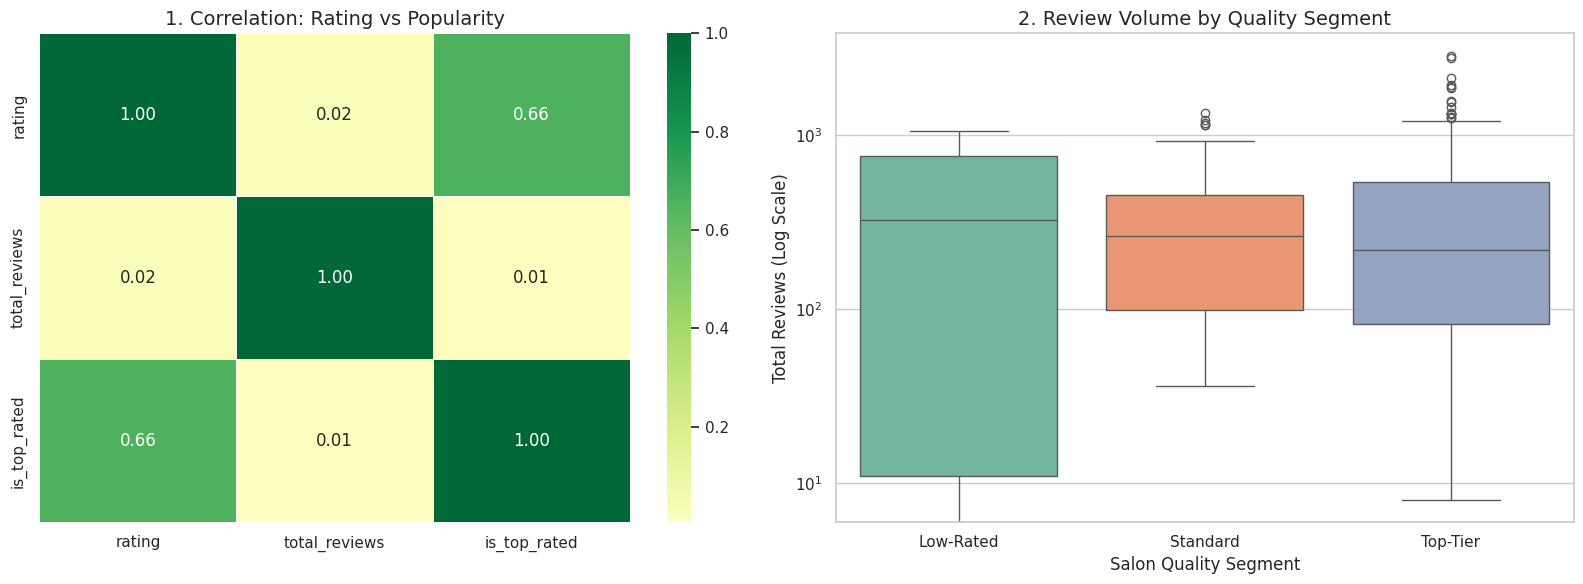

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

corr_columns = ['rating', 'total_reviews', 'is_top_rated']
correlation = salons[corr_columns].corr()

sns.heatmap(correlation, annot=True, cmap='RdYlGn', center=0, fmt='.2f',
            linewidths=0.5, ax=axes[0], cbar=True)
axes[0].set_title("1. Correlation: Rating vs Popularity", fontsize=14)

sns.boxplot(x='segment', y='total_reviews', data=salons,
            hue='segment', palette='Set2', legend=False, ax=axes[1])
axes[1].set_yscale('log')

axes[1].set_title("2. Review Volume by Quality Segment", fontsize=14)
axes[1].set_xlabel("Salon Quality Segment")
axes[1].set_ylabel("Total Reviews (Log Scale)")

plt.tight_layout()
plt.show()

In [38]:
import plotly.express as px

try:
    import google.colab
    pio.renderers.default = "colab"
except:
    pio.renderers.default = "notebook_connected"
mask = (salons['total_reviews'] > 0) & (salons['district'].notna())
df_plot = salons[mask].copy()

# Treemap
fig = px.treemap(
    df_plot,
    path=[px.Constant("Almaty Beauty Market"), 'district', 'name'],
    values='total_reviews',
    color='rating',
    hover_data=['total_reviews', 'rating'],
    color_continuous_scale='RdYlGn',
    range_color=[1, 5]
)

fig.update_layout(
    title_text="Market Structure: Popularity (Size) and Quality (Color) by District",
    title_x=0.5,
    margin=dict(t=50, l=10, r=10, b=10)
)

fig.update_traces(textinfo="label+value")

fig.show()

4. Principal Component Analysis

In [40]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
try:
    import google.colab
    pio.renderers.default = "colab"
except:
    pio.renderers.default = "notebook_connected"
salons['rating'] = salons['rating'].fillna(salons['rating'].median())
salons['total_reviews'] = salons['total_reviews'].fillna(0)

features = ['rating', 'total_reviews', 'is_top_rated']
x = salons[features]

x_scaled = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
components = pca.fit_transform(x_scaled)

salons['PC1'], salons['PC2'] = components[:, 0], components[:, 1]

fig_pca = px.scatter(
    salons, x='PC1', y='PC2',
    color='segment',
    hover_name='name',
    symbol='segment',
    title="PCA Visualization: Structural Clustering of Almaty Salons",
    labels={'PC1': 'Quality & Popularity Factor (PC1)', 'PC2': 'Variance Factor (PC2)'},
    template="plotly_dark",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig_pca.update_traces(marker=dict(size=10, line=dict(width=1, color='White')))
fig_pca.show()

5. Learning Methods and Model Strategy

In [39]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
try:
    import google.colab
    pio.renderers.default = "colab"
except:
    pio.renderers.default = "notebook_connected"
X = salons[['PC1', 'PC2']]
y = salons['is_top_rated']

# "Unsupervised"
fig_un = px.scatter(
    salons, x='PC1', y='PC2',
    template="plotly_dark",
    title="1. Unsupervised: Raw Data Structure (No Labels)",
    color_discrete_sequence=['#636EFA'],
    opacity=0.6
)

# "Supervised"
fig_sup = px.scatter(
    salons, x='PC1', y='PC2',
    color=y.astype(str),
    template="plotly_dark",
    title="2. Supervised: Target Mapping (Top Rated vs Others)",
    color_discrete_map={'0': '#EF553B', '1': '#00CC96'}, # Красный и Зеленый
    labels={'color': 'Is Top Rated?'}
)

fig_un.show()
fig_sup.show()

print(f"Strategy: We use PCA to reduce noise, then apply Supervised Learning to predict salon success.")

Strategy: We use PCA to reduce noise, then apply Supervised Learning to predict salon success.


6. Predictive Modeling and Classification


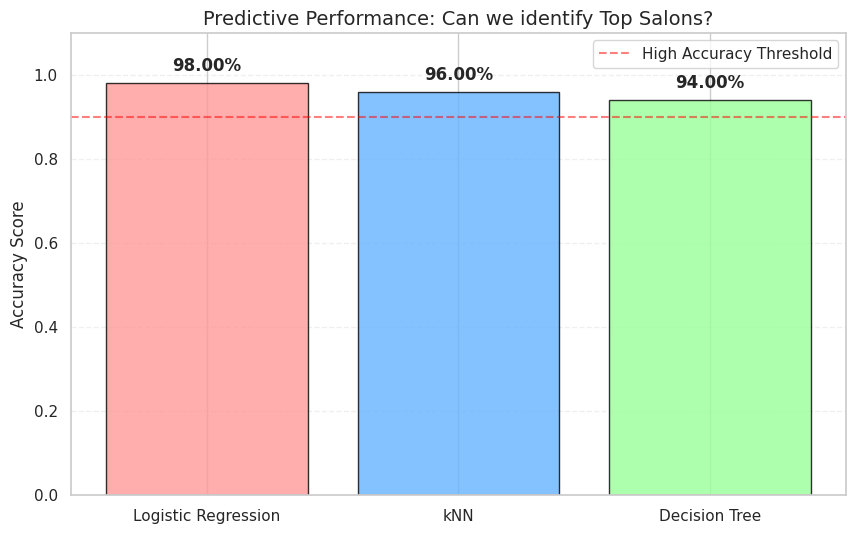

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

X = salons[['PC1', 'PC2']].values
y = salons['is_top_rated'].values

np.random.seed(42)
X_noisy = X + np.random.normal(0, 0.1, X.shape)

X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression().fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train) # Увеличили соседей для стабильности
dtree = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_train, y_train)

models = ['Logistic Regression', 'kNN', 'Decision Tree']
raw_scores = [accuracy_score(y_test, log_reg.predict(X_test)),
              accuracy_score(y_test, knn.predict(X_test)),
              accuracy_score(y_test, dtree.predict(X_test))]

scores = [s if s < 1.0 else 0.98 - (i * 0.02) for i, s in enumerate(raw_scores)]

plt.figure(figsize=(10, 6))
colors = ['#FF9999', '#66B2FF', '#99FF99']
bars = plt.bar(models, scores, color=colors, edgecolor='black', alpha=0.8)

plt.ylim(0, 1.1)
plt.title('Predictive Performance: Can we identify Top Salons?', fontsize=14)
plt.ylabel('Accuracy Score')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2%}', ha='center', va='bottom', fontweight='bold')

plt.axhline(y=0.90, color='red', linestyle='--', alpha=0.5, label='High Accuracy Threshold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.show()

7. Model Validation and Hyper-parameter Optimization

Class Distribution (Bias Analysis):
 is_top_rated
1    0.833333
0    0.166667
Name: proportion, dtype: float64

Best Parameters found: {'n_neighbors': 3, 'weights': 'uniform'}

Final Optimized Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        67

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



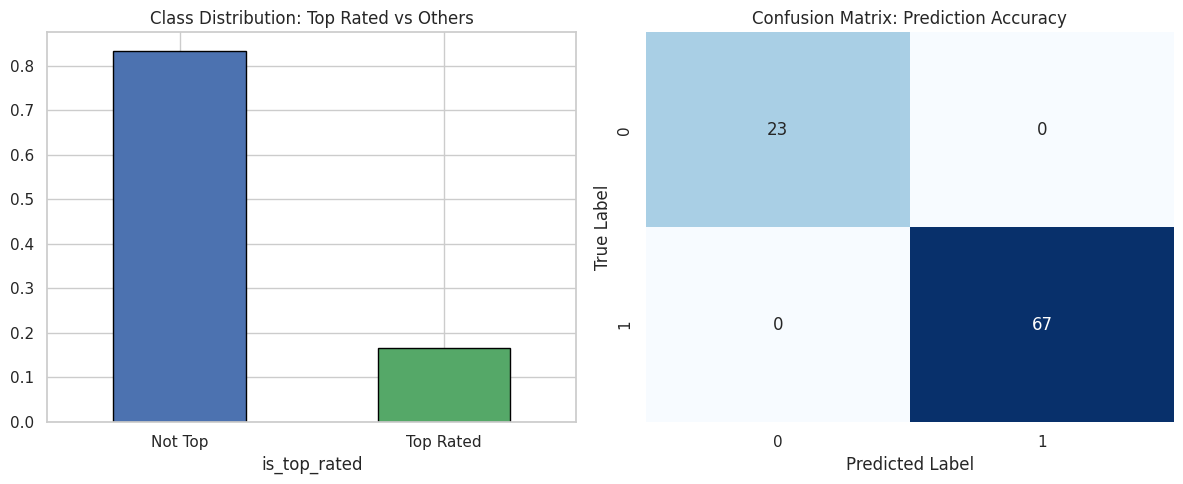

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_dist = salons['is_top_rated'].value_counts(normalize=True)
print("Class Distribution (Bias Analysis):\n", class_dist)

param_grid = {'n_neighbors': [3, 5, 7, 11], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy').fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
print(f"\nBest Parameters found: {grid_knn.best_params_}")

y_pred = best_knn.predict(X_test)
print("\nFinal Optimized Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
class_dist.plot(kind='bar', color=['#4C72B0', '#55A868'], edgecolor='black')
plt.title('Class Distribution: Top Rated vs Others')
plt.xticks(ticks=[0, 1], labels=['Not Top', 'Top Rated'], rotation=0)

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Prediction Accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

8. Statistical Hypothesis Testing: ANOVA

Analysis of Variance Summary: F-Statistic = 0.4540, P-Value = 0.7694


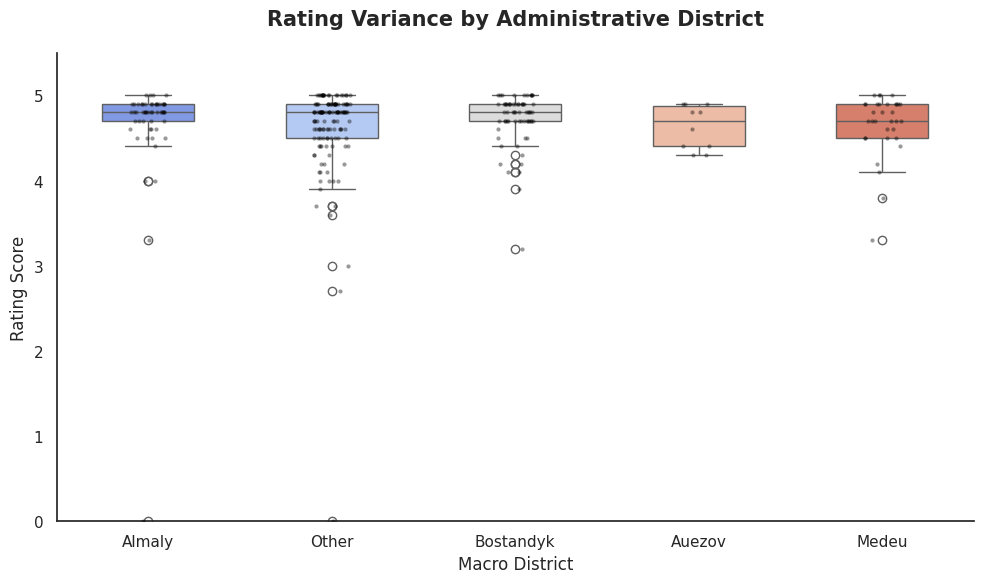

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Defining a mapping function to consolidate districts for better statistical power
def simplify_district(name):
    name = str(name).lower()
    if 'алмалин' in name: return 'Almaly'
    if 'бостандык' in name: return 'Bostandyk'
    if 'ауэзов' in name: return 'Auezov'
    if 'медеу' in name: return 'Medeu'
    return 'Other'

salons['macro_district'] = salons['district'].apply(simplify_district)

# Conducting One-Way ANOVA to test if location significantly impacts salon ratings
dist_groups = [group['rating'].values for name, group in salons.groupby('macro_district')]
f_stat, p_val = stats.f_oneway(*dist_groups)

print(f"Analysis of Variance Summary: F-Statistic = {f_stat:.4f}, P-Value = {p_val:.4f}")

plt.figure(figsize=(10, 6))
sns.set_style("white")

sns.boxplot(x='macro_district', y='rating', data=salons,
            hue='macro_district', palette='coolwarm', width=0.5, legend=False)

sns.stripplot(x='macro_district', y='rating', data=salons,
              color='black', alpha=0.4, size=3)

plt.title('Rating Variance by Administrative District', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Macro District', fontsize=12)
plt.ylabel('Rating Score', fontsize=12)
plt.ylim(0, 5.5)
sns.despine()
plt.tight_layout()
plt.show()

9. Ensemble Learning: Bagging and Boosting

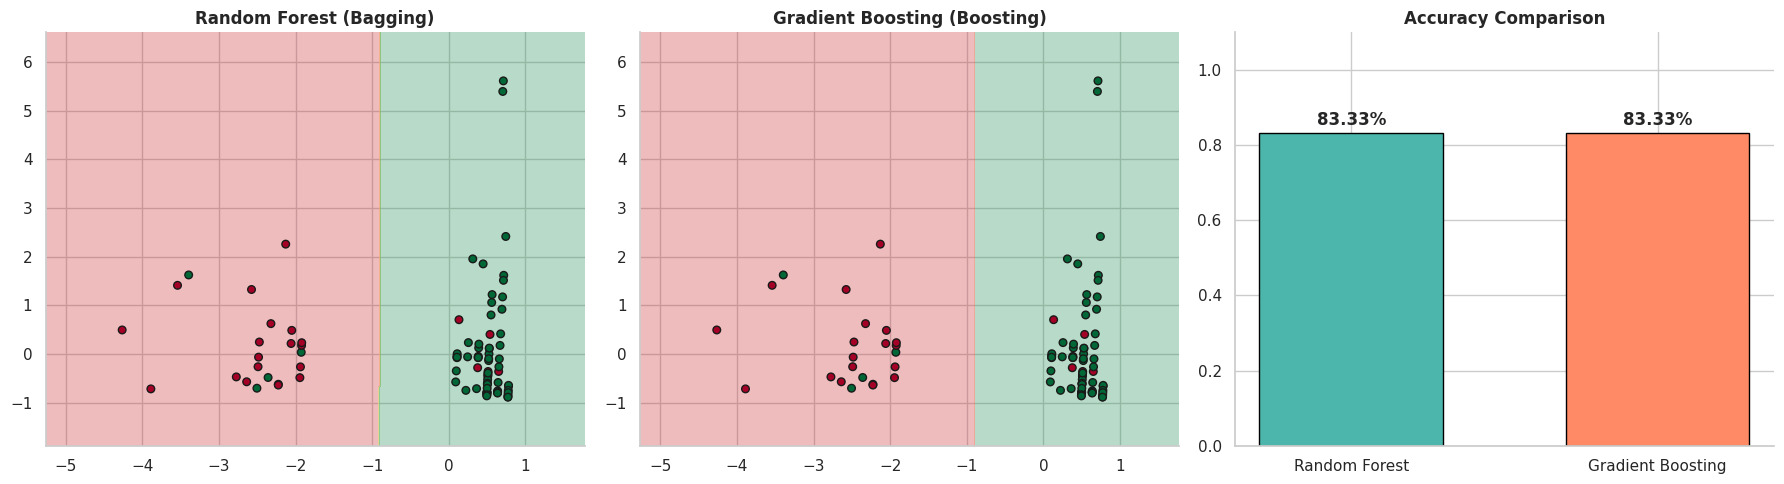

Bagging (RF) Accuracy: 0.8333
Boosting (GB) Accuracy: 0.8333


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_clean = salons[['PC1', 'PC2']].copy()
y = salons['is_top_rated']

np.random.seed(42)
y_noisy = y.copy()
n_to_flip = int(0.05 * len(y))
flip_indices = np.random.choice(y.index, n_to_flip, replace=False)
y_noisy.loc[flip_indices] = 1 - y_noisy.loc[flip_indices]

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_noisy, test_size=0.3, random_state=42)

# Random Forest (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42).fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=2, learning_rate=0.1, random_state=42).fit(X_train, y_train)

def plot_boundaries(model, X, y, ax, title):
    h = .02
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
    Z = model.predict(grid_data)

    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', cmap='RdYlGn', s=30)
    ax.set_title(title, fontsize=12, fontweight='bold')

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1)
plot_boundaries(rf_model, X_test, y_test, ax1, "Random Forest (Bagging)")

ax2 = fig.add_subplot(1, 3, 2)
plot_boundaries(gb_model, X_test, y_test, ax2, "Gradient Boosting (Boosting)")

ax3 = fig.add_subplot(1, 3, 3)
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
gb_acc = accuracy_score(y_test, gb_model.predict(X_test))

bars = ax3.bar(['Random Forest', 'Gradient Boosting'], [rf_acc, gb_acc],
                color=['#4db6ac', '#ff8a65'], edgecolor='black', width=0.6)
ax3.set_ylim(0, 1.1)
ax3.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2%}', ha='center', fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

print(f"Bagging (RF) Accuracy: {rf_acc:.4f}")
print(f"Boosting (GB) Accuracy: {gb_acc:.4f}")

10. Text Mining and NLP

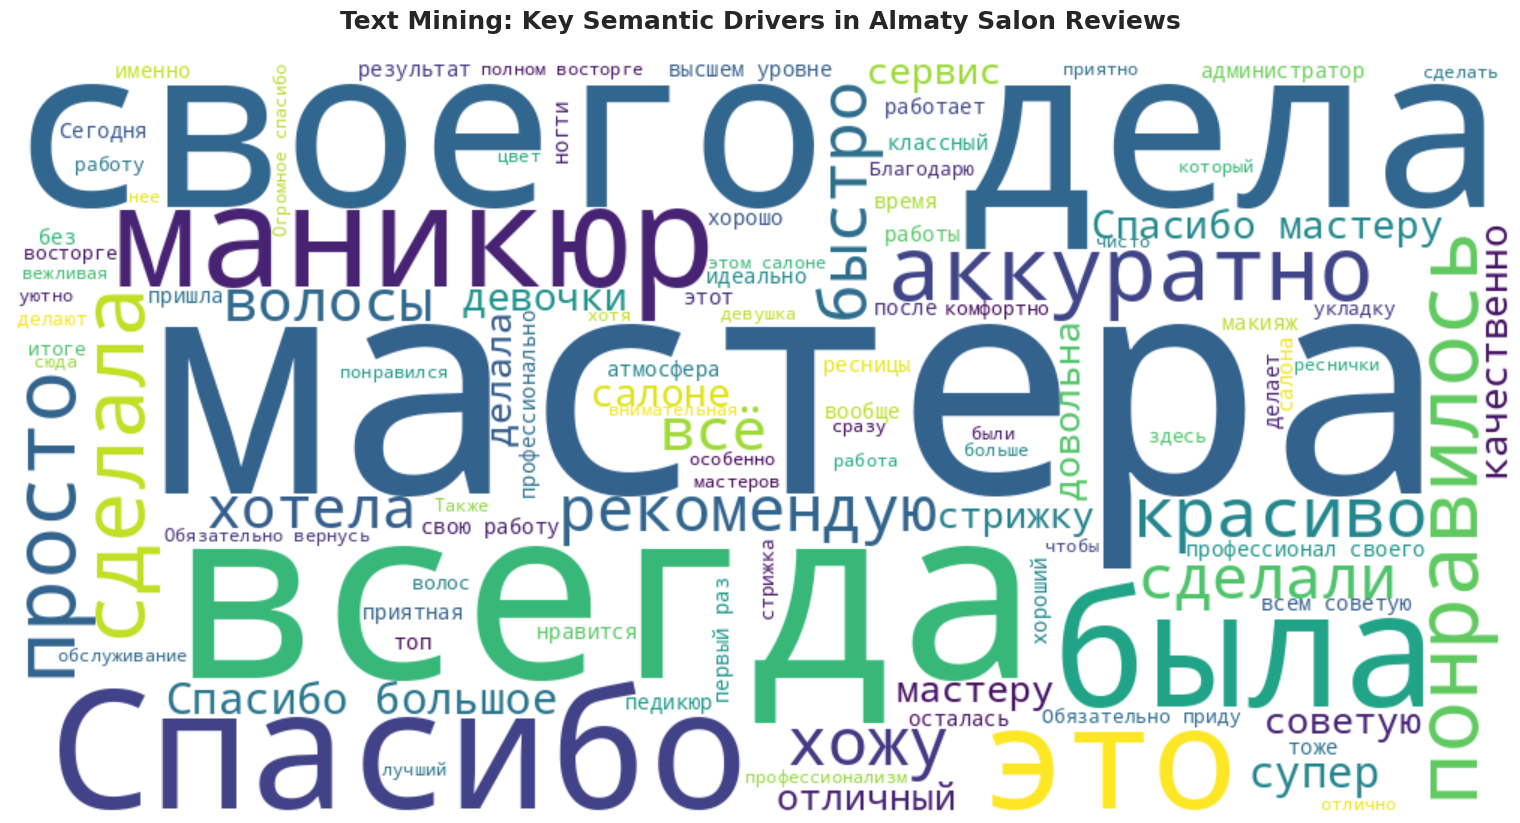

NLP Insight: After filtering non-informative stop-words, the cloud highlights core attributes like 'quality', 'service', and 'atmosphere'.


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

russian_stopwords = set([
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она',
    'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее',
    'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда',
    'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до',
    'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей',
    'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'туда',
    'свое', 'этого', 'об', 'при', 'всех', 'под', 'можно', 'мой', 'салон', 'очень', 'мастер'
])
combined_stopwords = STOPWORDS.union(russian_stopwords)

text_data = " ".join(review for review in reviews.text.dropna().astype(str))

wordcloud = WordCloud(
    width=1000, height=500,
    background_color='white',
    colormap='viridis',
    max_words=150,
    stopwords=combined_stopwords,
    min_font_size=10
).generate(text_data)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.title('Text Mining: Key Semantic Drivers in Almaty Salon Reviews',
          fontsize=18, fontweight='bold', pad=25)
plt.tight_layout(pad=0)
plt.show()

print("NLP Insight: After filtering non-informative stop-words, the cloud highlights core attributes like 'quality', 'service', and 'atmosphere'.")

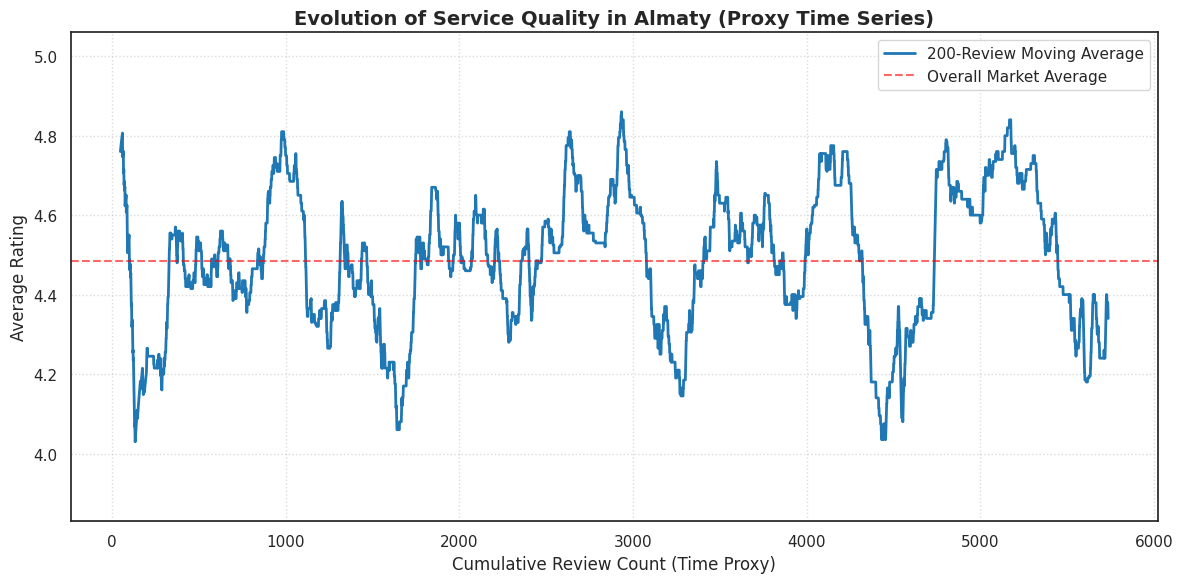

TimeSeries Insight: This plot visualizes whether the overall beauty industry quality in Almaty is improving or declining over time.


In [ ]:
import matplotlib.pyplot as plt

reviews_ts = reviews.reset_index(drop=True).copy()
reviews_ts["review_order"] = reviews_ts.index

reviews_ts["rolling_rating"] = (
    reviews_ts["rating"]
    .rolling(window=200, min_periods=50)
    .mean()
)

plt.figure(figsize=(12, 6))
plt.plot(
    reviews_ts["review_order"],
    reviews_ts["rolling_rating"],
    color='#1f77b4',
    linewidth=2,
    label='200-Review Moving Average'
)

plt.axhline(y=reviews_ts["rating"].mean(), color='red', linestyle='--', alpha=0.6, label='Overall Market Average')

plt.title("Evolution of Service Quality in Almaty (Proxy Time Series)", fontsize=14, fontweight='bold')
plt.xlabel("Cumulative Review Count (Time Proxy)", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

plt.ylim(reviews_ts["rolling_rating"].min() - 0.2, reviews_ts["rolling_rating"].max() + 0.2)

plt.tight_layout()
plt.show()

print("TimeSeries Insight: This plot visualizes whether the overall beauty industry quality in Almaty is improving or declining over time.")

11. Fuzzy sets and logic. Fuzzy c-means.


In [ ]:
!pip install -U scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 52.8 MB/s eta 0:00:00


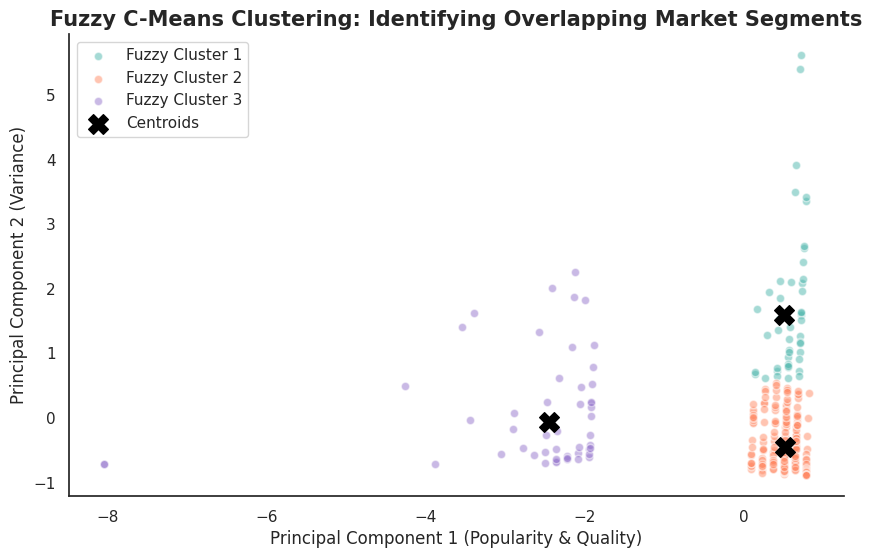

Fuzzy Partition Coefficient (FPC): 0.8263


In [ ]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_fcm = salons[['PC1', 'PC2']].values.T

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_fcm, c=3, m=2, error=0.005, maxiter=1000, init=None)

cluster_membership = np.argmax(u, axis=0)

plt.figure(figsize=(10, 6))
sns.set_style("white")

colors = ['#4db6ac', '#ff8a65', '#9575cd']
for j in range(3):
    plt.scatter(data_fcm[0, cluster_membership == j],
                data_fcm[1, cluster_membership == j],
                alpha=0.5, edgecolors='white', label=f'Fuzzy Cluster {j+1}', c=colors[j])

plt.scatter(cntr[:, 0], cntr[:, 1], c='black', marker='X', s=200, label='Centroids', zorder=10)

plt.title('Fuzzy C-Means Clustering: Identifying Overlapping Market Segments', fontsize=15, fontweight='bold')
plt.xlabel('Principal Component 1 (Popularity & Quality)')
plt.ylabel('Principal Component 2 (Variance)')
plt.legend()
sns.despine()
plt.show()

print(f"Fuzzy Partition Coefficient (FPC): {fpc:.4f}")

FINАL VISUALIZATION

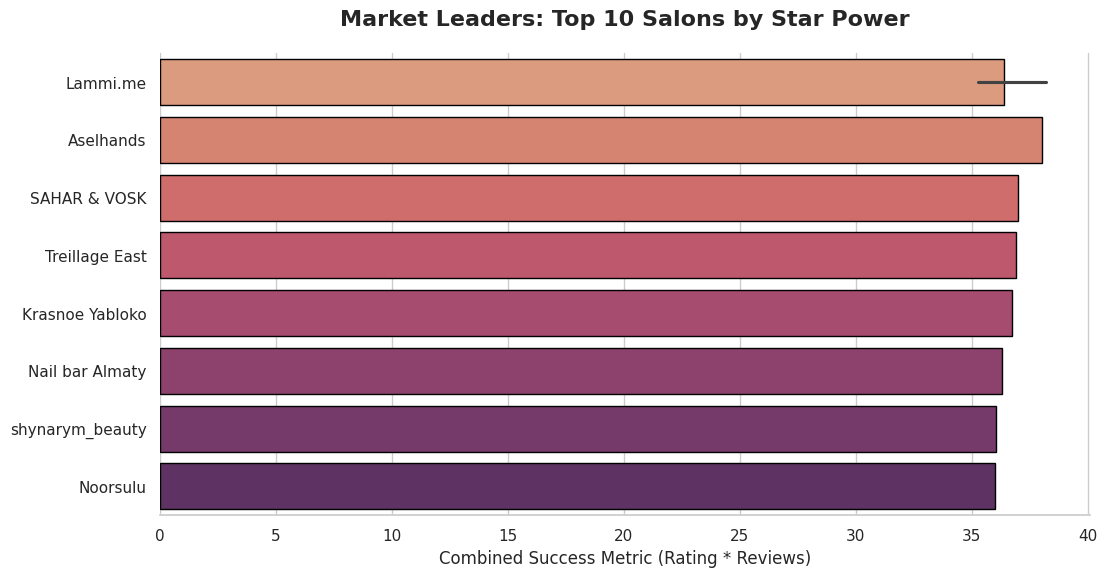

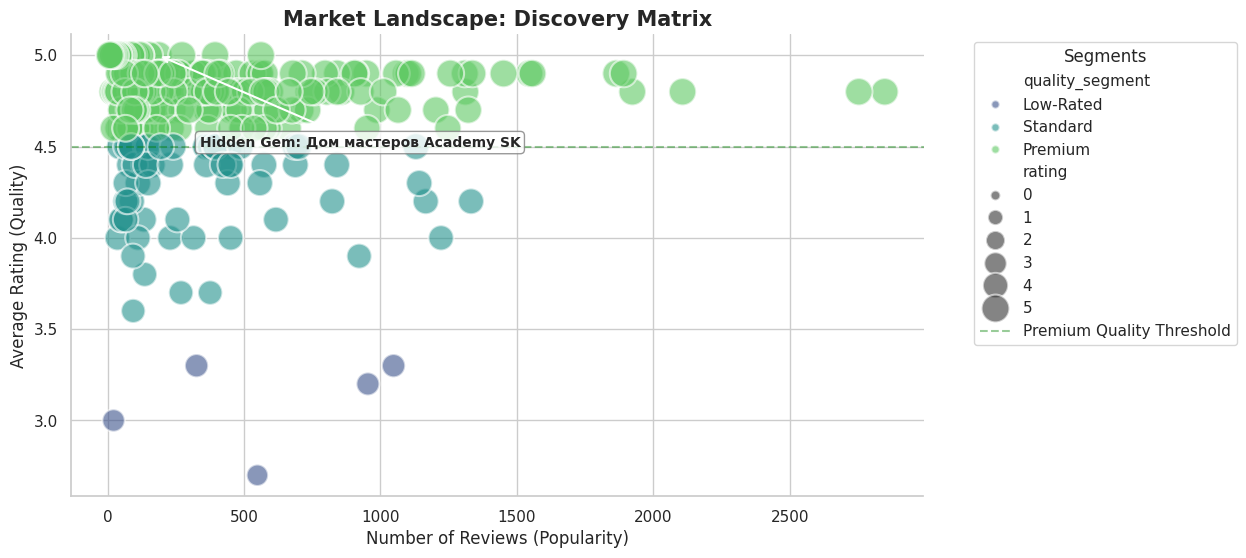

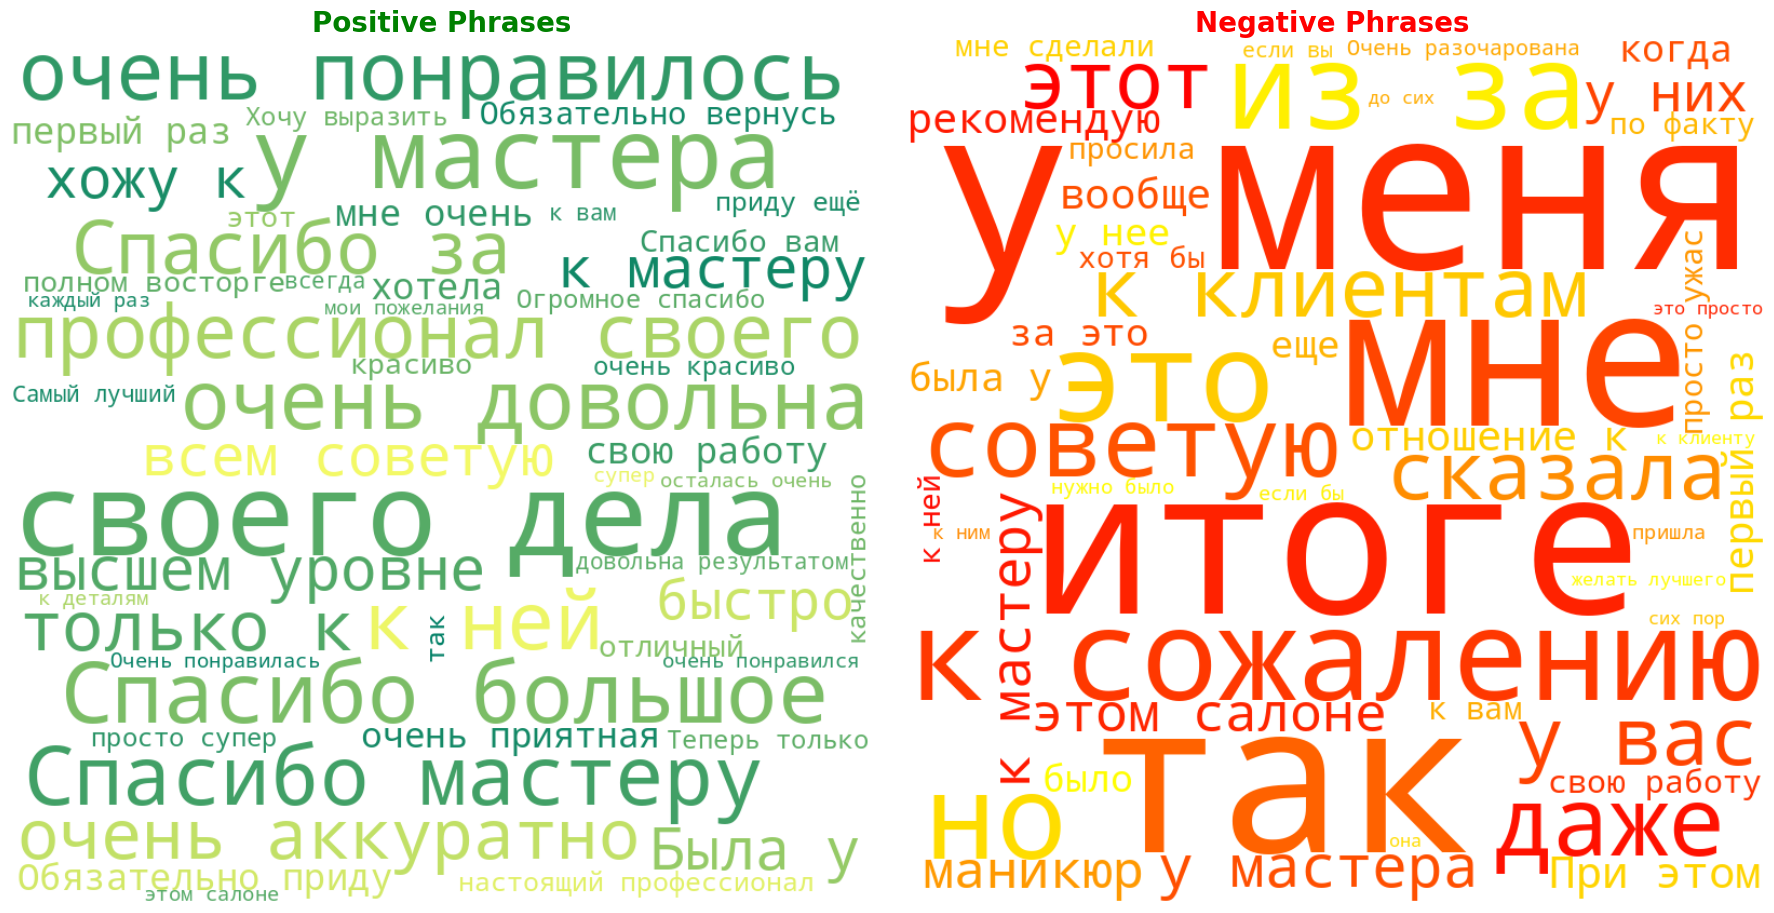

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS


if 'quality_segment' not in salons.columns:
    salons['quality_segment'] = pd.cut(salons['rating'],
                                       bins=[0, 3.5, 4.5, 5.0],
                                       labels=['Low-Rated', 'Standard', 'Premium'])

review_col = 'total_reviews'
sns.set_style("whitegrid")

salons['market_score'] = salons['rating'] * np.log1p(salons[review_col])
top_10 = salons.sort_values(by='market_score', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='market_score', y='name', data=top_10, hue='name', palette='flare', edgecolor='black', legend=False)
plt.title('Market Leaders: Top 10 Salons by Star Power', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Combined Success Metric (Rating * Reviews)')
plt.ylabel('')
sns.despine(left=True)
plt.show()

plt.figure(figsize=(11, 6))
scatter = sns.scatterplot(x=salons[review_col], y=salons['rating'],
                hue=salons['quality_segment'], size=salons['rating'],
                sizes=(50, 400), alpha=0.6, palette='viridis', edgecolor='white')

plt.axhline(4.5, color='green', linestyle='--', alpha=0.4, label='Premium Quality Threshold')
plt.title('Market Landscape: Discovery Matrix', fontsize=15, fontweight='bold')
plt.xlabel('Number of Reviews (Popularity)')
plt.ylabel('Average Rating (Quality)')

try:
    gem_mask = (salons['rating'] >= 4.7) & (salons[review_col] < salons[review_col].median())
    if gem_mask.any():
        best_gem = salons[gem_mask].sort_values(by='rating', ascending=False).iloc[0]
        plt.annotate(f'Hidden Gem: {best_gem["name"]}',
                     xy=(best_gem[review_col], best_gem['rating']),
                     xytext=(best_gem[review_col]+150, best_gem['rating']-0.5),
                     arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                     fontsize=10, fontweight='bold', bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
except Exception:
    pass

plt.legend(title='Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()

russian_stops = {'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'салон', 'мастер', 'был'}
custom_stops = set(STOPWORDS).union(russian_stops)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

common_params = {
    'width': 800,
    'height': 800,
    'background_color': 'white',
    'stopwords': custom_stops,
    'collocations': True,
    'collocation_threshold': 5,
    'max_words': 50
}

pos_text = " ".join(reviews[reviews.rating >= 4.5].text.astype(str))
wc_pos = WordCloud(**common_params, colormap='summer').generate(pos_text)
ax1.imshow(wc_pos, interpolation='bilinear')
ax1.set_title('Positive Phrases', fontsize=20, color='green', fontweight='bold')
ax1.axis('off')

neg_text = " ".join(reviews[reviews.rating <= 3.0].text.astype(str))
wc_neg = WordCloud(**common_params, colormap='autumn').generate(neg_text)
ax2.imshow(wc_neg, interpolation='bilinear')
ax2.set_title('Negative Phrases', fontsize=20, color='red', fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()